In [16]:
import spade
import random
from spade.agent import Agent
from spade.behaviour import CyclicBehaviour
from spade.message import Message

class Grid:
    def __init__(self, width, height):
        self.width = width
        self.height = height
        self.grid = [[None for _ in range(width)] for _ in range(height)]

    def is_position_free(self, x, y):
        return self.grid[y][x] is None

    def move_agent(self, agent, x, y):
        # Eliminar al agente de su posición actual
        for i, row in enumerate(self.grid):
            for j, current_agent in enumerate(row):
                if current_agent == agent:
                    self.grid[i][j] = None
                    break

        # Colocar al agente en la nueva posición
        self.grid[y][x] = agent

    def find_free_position(self):
        free_positions = [(x, y) for x in range(self.width) for y in range(self.height) if self.is_position_free(x, y)]
        return random.choice(free_positions) if free_positions else None
    
    def get_neighbors(self, x, y):
        neighbors = []
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                nx, ny = x + dx, y + dy
                if 0 <= nx < self.width and 0 <= ny < self.height and (dx != 0 or dy != 0):
                    neighbors.append(self.grid[ny][nx])
        return neighbors


In [31]:


class IndividualAgent(Agent):
    def __init__(self, jid, password, agent_type, tolerance, grid):
        super().__init__(jid, password)
        self.agent_type = agent_type
        self.tolerance = tolerance
        self.grid = grid
        self.x, self.y = self.grid.find_free_position()
        self.grid.move_agent(self, self.x, self.y)
        self.is_satisfied = True

    class EvaluateNeighborhoodBehaviour(CyclicBehaviour):
        async def run(self):
            neighbors = self.agent.grid.get_neighbors(self.agent.x, self.agent.y)
            similar = sum(1 for n in neighbors if n and n.agent_type == self.agent.agent_type)
            total = sum(1 for n in neighbors if n)
            self.agent.is_satisfied = (similar / total) >= self.agent.tolerance if total > 0 else True
            #print(f"{self.agent.name} está {'satisfecho' if self.agent.is_satisfied else 'insatisfecho'}")

            if total > 0 and (similar / total) < self.agent.tolerance:
                # Agente insatisfecho, buscar nueva posición
                
                new_position = self.agent.grid.find_free_position()
                if new_position:
                    self.agent.grid.move_agent(self.agent, *new_position)
                    self.agent.x, self.agent.y = new_position
                    
            await asyncio.sleep(2)
                    

    async def setup(self):
        self.add_behaviour(self.EvaluateNeighborhoodBehaviour())



In [32]:
def create_agents(num_agents, tolerance_threshold, grid):
    agents = []
    for i in range(num_agents):
        agent_type = random.choice(["A", "B"])
        agent_jid = f"individual_{i}@gtirouter.dsic.upv.es"
        agent = IndividualAgent(agent_jid, "password", agent_type, tolerance_threshold, grid)
        agents.append(agent)
    return agents


In [37]:
import matplotlib.pyplot as plt

def visualize_grid(grid):
    fig, ax = plt.subplots()
    for y in range(grid.height):
        for x in range(grid.width):
            agent = grid.grid[y][x]
            if agent is not None:
                if agent.agent_type == "A":
                    color = 'blue'
                else:
                    color = 'red'
                ax.scatter(x, y, c=color)

    ax.set_xlim(-1, grid.width)
    ax.set_ylim(-1, grid.height)
    ax.set_xticks(range(grid.width))
    ax.set_yticks(range(grid.height))
    ax.grid(True)
    plt.show()

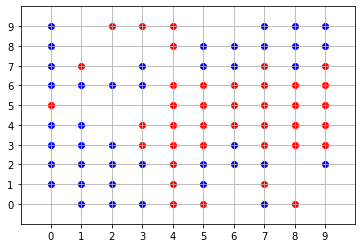

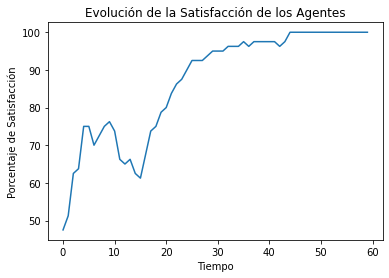

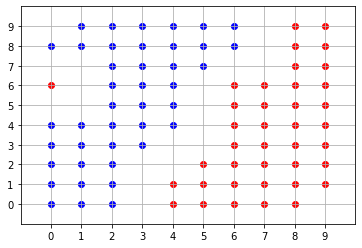

In [38]:
import time
import asyncio
import matplotlib.pyplot as plt

grid = Grid(10, 10)  # Cuadrícula de 10x10
agents = create_agents(80, 0.7, grid)  # X agentes con un umbral de tolerancia del Y%
await asyncio.sleep(5)

for agent in agents:
    await agent.start()
    
visualize_grid(grid)

satisfaction_rates = []
execution_time = 60  # Ejecutar por XX segundos
start_time = time.time()

while time.time() - start_time < execution_time:
    await asyncio.sleep(1)  # Registrar cada X segundos
    satisfied_agents = sum(agent.is_satisfied for agent in agents)
    total_agents = len(agents)
    satisfaction_rate = (satisfied_agents / total_agents) * 100
    satisfaction_rates.append(satisfaction_rate)

# Detener a todos los agentes
for agent in agents:
    await agent.stop()

# Mostrar la gráfica de la evolución de la satisfacción
plt.plot(satisfaction_rates)
plt.xlabel('Tiempo')
plt.ylabel('Porcentaje de Satisfacción')
plt.title('Evolución de la Satisfacción de los Agentes')
plt.show()

visualize_grid(grid)

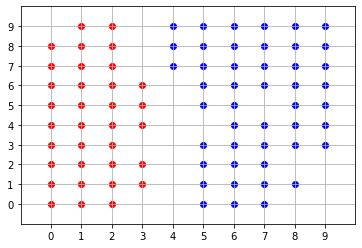